In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df=pd.read_csv("cleaned_data_PES2201800211.csv")
print("Shape:",df.shape)
df.head()

Shape: (96, 11)


,Unnamed: 0,community,age,weight,delivery_phase,hb,ifa,bp,education,residence,result
0,0,1,21.0,42.0,1.0,9.2,1,1.375,5.0,1.0,0
1,1,1,21.0,36.0,1.0,8.8,1,1.500,5.0,1.0,0
2,2,1,21.0,36.0,1.0,9.2,1,2.125,5.0,1.0,0
3,3,1,21.0,36.0,1.0,8.0,1,1.375,5.0,1.0,0
4,4,1,24.0,33.0,1.0,9.3,1,1.571,5.0,1.0,0


In [2]:
nulls=df.isnull().sum()
nulls
#(nulls*100)/96

Unnamed: 0        0
community         0
age               0
weight            0
delivery_phase    0
hb                0
ifa               0
bp                0
education         0
residence         0
result            0
dtype: int64

In [3]:
#Residence counts
print("No.of 1's",np.sum(df["residence"]==1))
print("No.of 2's",np.sum(df["residence"]==2))
df.residence.values[df.residence.values==1]=0
df.residence.values[df.residence.values==2]=1
# df.Residence.fillna(0,inplace=True)

No.of 1's 83
No.of 2's 13


In [4]:
#Delivery Phase
print("No.of 1's",np.sum(df["delivery_phase"]==1))
print("No.of 2's",np.sum(df["delivery_phase"]==2))
# df.drop(['delivery_phase','education'],axis=1,inplace=True)

No.of 1's 94
No.of 2's 2


In [5]:
# IFA
print("No.of 1's",np.sum(df["ifa"]==0))
print("No.of 2's",np.sum(df["ifa"]==1))

No.of 1's 30
No.of 2's 66


count    96.000000
mean     23.753053
std       3.196334
min      17.000000
25%      21.000000
50%      24.000000
75%      25.250000
max      38.000000
Name: age, dtype: float64


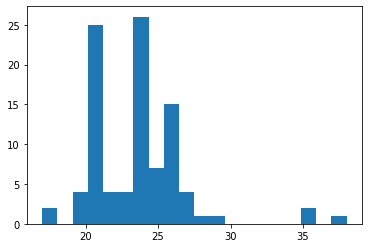

23.753052917232026


In [6]:
ages=df["age"].notnull()
age=df["age"]
ages=age[ages]
print(ages.describe())
plt.hist(ages,bins=20)
plt.show()
age.fillna(ages.median(),inplace=True)
print(df['age'].mean())

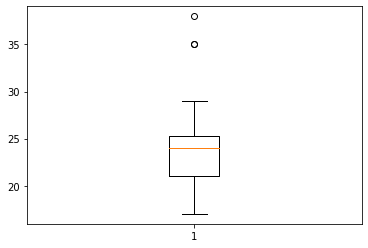

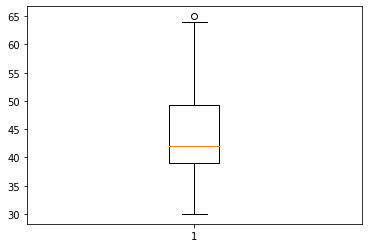

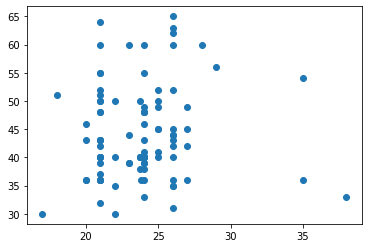

count    96.000000
mean     44.083333
std       8.259816
min      30.000000
25%      39.000000
50%      42.000000
75%      49.250000
max      65.000000
Name: weight, dtype: float64


In [7]:
wts=df['weight'].notnull()
cor_age=df.age[wts]
cor_wts=df.weight[wts]
plt.boxplot(df.age)
plt.show()
plt.boxplot(df.weight)
plt.show()
cor=np.cov(cor_age,cor_wts)
cor[0,1]/(cor_age.std()*cor_wts.std())
plt.scatter(cor_age,cor_wts)
plt.show()
print(cor_wts.describe())
df.weight.fillna(cor_wts.mean(),inplace=True)

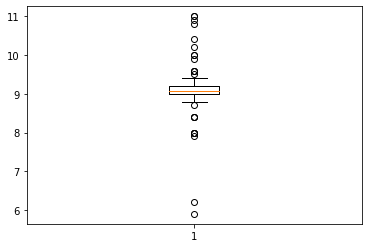

In [8]:
h=df['hb'].notnull()
hbs=df.hb[h].to_numpy()
lo=hbs>=8.45
hi=hbs<=9.65
hb=hbs[lo & hi]
plt.boxplot(hbs)
plt.show()
#print(pd.Series(hbs).describe(),pd.Series(hb).describe())
df.hb.fillna(hb.mean(),inplace=True)

In [9]:

b=df['bp'].notnull()
bps=df.bp[h]
bps.describe()
df.bp.fillna(bps.mean(),inplace=True)
one_hot=pd.get_dummies(df['community'])
df=df.drop('community',axis=1)
df=df.join(one_hot)
df=df.reindex(columns=[1,4,'age','weight','hb','delivery_phase','education','ifa','bp','residence','result'])
df.head()

,1,4,age,weight,hb,delivery_phase,education,ifa,bp,residence,result
0,1,0,21.0,42.0,9.2,1.0,5.0,1,1.375,0.0,0
1,1,0,21.0,36.0,8.8,1.0,5.0,1,1.500,0.0,0
2,1,0,21.0,36.0,9.2,1.0,5.0,1,2.125,0.0,0
3,1,0,21.0,36.0,8.0,1.0,5.0,1,1.375,0.0,0
4,1,0,24.0,33.0,9.3,1.0,5.0,1,1.571,0.0,0


In [10]:
def sigmoid(Z):
  return 1/(np.exp(-Z)+1)
def relu(Z):
  return np.maximum(0,Z)

In [11]:
def init_parameters(dims):
  parameters={}
  for l in range(1,len(dims)):
    parameters["W"+ str(l)]=np.random.randn(dims[l],dims[l-1])*np.sqrt(2/dims[l-1])
    parameters["b"+ str(l)]=np.zeros(shape=(dims[l],1))
    #limit=np.sqrt(6/(dims[l]+dims[l-1]))
    # parameters["W"+ str(l)]=np.random.uniform(-limit,limit,size=(dims[l],dims[l-1]))
    # parameters["b"+ str(l)]=np.random.uniform(-limit,limit,size=(dims[l],1))
  return parameters

def forward_activation(A,W,b,activation):
  Z=W.dot(A)+b
  if activation=="relu":
    A_new=relu(Z)
  elif activation=="sigmoid":
    A_new=sigmoid(Z)
  cache=((A,W,b),Z)
  return A_new,cache

def forward_propogate(X,parameters):
  L=len(parameters)//2
  caches=[]
  A=X
  for l in range(1,L):
    A_prev=A
    A,cache=forward_activation(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],"sigmoid")
    caches.append(cache)
  #Last layer
  O,cache=forward_activation(A,parameters["W"+str(L)],parameters["b"+str(L)],"sigmoid")
  caches.append(cache)
  return O,caches

In [12]:
def compute_cost(O,Y,parameters,lambd):
  assert(O.shape == Y.shape)
  m=Y.shape[1]
  #print("examples:",m)
  cost=(1./m)*(-np.dot(Y,np.log(O).T)-np.dot(1-Y,np.log(1-O).T))
  cost=np.squeeze(cost)
  assert(cost.shape==())
  L=len(parameters)//2
  reg_cost=0
  for l in range(1,L+1):
    reg_cost+=(1/m) * (lambd/2) * np.sum(parameters["W"+str(l)]**2)
  return cost   #+reg_cost

In [13]:
#Back Propogation
def relu_diff(da,z):
  dz=da.copy()
  dz[z<=0]=0
  return dz
def sigmoid_diff(da,z):
  a=sigmoid(z)
  dz=da*a*(1-a)
  return dz

def backward_activation(da,cache,activation):
  cache1,cache2=cache
  lambd=0.7
  if activation=="relu":
    dz=relu_diff(da,cache2)
  elif activation=="sigmoid":
    dz=sigmoid_diff(da,cache2)
  a_prev,W,b=cache1
  m=a_prev.shape[1]
  da_prev=np.dot(W.T,dz)
  dW=np.dot(dz,a_prev.T)*(1./m)#+(lambd/m) * W
  db=np.sum(dz,axis=1,keepdims=True)*(1./m)
  return da_prev,dW,db

def back_propogate(O,Y,caches):
  grads={}
  m=O.shape[1]
  L=len(caches)
  Y=Y.reshape(O.shape)

  dO=-(np.divide(Y,O)-np.divide(1-Y,1-O))
  current_cache=caches[L-1]
  grads["dA"+str(L-1)],grads["dW"+str(L)],grads["db"+str(L)]=backward_activation(dO,current_cache,"sigmoid")

  for l in reversed(range(L-1)):
    current_cache=caches[l]
    grads["dA"+str(l)],grads["dW"+str(l+1)],grads["db"+str(l+1)]=backward_activation(grads["dA"+str(l+1)],current_cache,"sigmoid")

  return grads

In [14]:
def update_parameters(parameters,v,grads,learning_rate):
    L = len(parameters) // 2 # number of layers in the neural networks
    beta=0.9
    # Momentum update for each parameter
    for l in range(L):
        
        ### START CODE HERE ### (approx. 4 lines)
        # compute velocities
        v["dW" + str(l+1)] = beta * v["dW" + str(l+1)] + (1-beta) * grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta * v["db" + str(l+1)] + (1-beta) * grads['db' + str(l+1)]
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v['db' + str(l+1)]
        ### END CODE HERE ###
        
    return parameters, v

In [15]:
def predict(X,Y,parameters):
  #print(X[:,[0,5,10]])
  m=X.shape[1]
  n=len(parameters)//2
  predictions=np.zeros((1,m))
  prob,cache=forward_propogate(X,parameters)
  for i in range(0,prob.shape[1]):
    if prob[0][i] > 0.5:
        predictions[0][i]=1
    else:
        predictions[0][i]=0
  #print("Accuracy: "+str(np.sum(predictions[0]==Y[0])))
  print("Accuracy: "  + str(np.sum((predictions == Y)/m)))
  return predictions

In [16]:
def initialize_velocity(parameters):
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l+1)] = np.zeros_like(parameters['W' + str(l+1)])
        v["db" + str(l+1)] = np.zeros_like(parameters['b' + str(l+1)])
        ### END CODE HERE ###
        
    return v

In [40]:
def model(X,Y,layer_dims,learning_rate=1/3,num_iterations=5000,print_cost=False):
  parameters=init_parameters(layers_dims)
  v=initialize_velocity(parameters)
  costs=[]
  for i in range(num_iterations):
    O,caches=forward_propogate(X,parameters)
    cost=compute_cost(O,Y,parameters,0.7)
    grads=back_propogate(O,Y,caches)
    parameters,v=update_parameters(parameters,v,grads,learning_rate)
    #print(O,len(O[0]))
    if print_cost and i%5000==0:
      print("Cost after",i,"iteration:",cost)
      costs.append(cost)
  plt.plot(costs)
  plt.ylabel('cost')
  plt.xlabel('iterations per 100')
  plt.title("learning rate="+str(learning_rate))
  plt.show()

  return parameters

In [41]:
data=df.to_numpy()
X_temp=data[:,[4,5,6]]
#print(X_temp[:5,:],np.sum(X_temp,axis=0))
mean=np.sum(X_temp,axis=0)/X_temp.shape[0]
X_temp-=mean
#print(X_temp[:5,:])
X_sigma=np.sum(X_temp**2,axis=0)/X_temp.shape[0]
data[:,[4,5,6]]=X_temp/np.sqrt(X_sigma)
np.savetxt("cleaned.csv",data,delimiter=',')
X=data[:,:-1]
Y=data[:,-1]
print(np.sum(Y==0),np.sum(Y==1))
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=.30,random_state=11)
print(X_train.T.shape,X_test.T.shape,Y_train.T.shape,Y_test.T.shape,X_train.T[:,50],Y_train.reshape((1,len(Y_train)))[0,50])

24 72
(10, 67) (10, 29) (67,) (29,) [ 1.00000000e+00  0.00000000e+00  2.37313433e+01  4.00000000e+01
  3.20370495e-02 -1.45864991e-01  1.79605302e-01  0.00000000e+00
  1.57100000e+00  0.00000000e+00] 1.0


Cost after 0 iteration: 0.7806283409582891
Cost after 5000 iteration: 0.284738545406905
Cost after 10000 iteration: 0.2786475349867288
Cost after 15000 iteration: 0.2768974470649255
Cost after 20000 iteration: 0.2760072373526942
Cost after 25000 iteration: 0.2754334824728655
Cost after 30000 iteration: 0.2750155687005144
Cost after 35000 iteration: 0.2746837449127953
Cost after 40000 iteration: 0.2743936958184665
Cost after 45000 iteration: 0.2741251673015571
Cost after 50000 iteration: 0.27391332167168175
Cost after 55000 iteration: 0.273754154470568
Cost after 60000 iteration: 0.27362904319920045
Cost after 65000 iteration: 0.2735286175476887
Cost after 70000 iteration: 0.2734466482282858
Cost after 75000 iteration: 0.27337872105191474


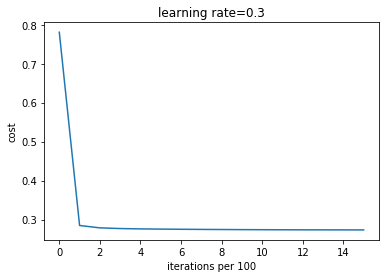

In [42]:
layers_dims=(10,10,3,1)
parameters=model(X_train.T,Y_train.reshape((1,len(Y_train))),layers_dims,learning_rate=0.3,num_iterations=80000,print_cost=True)

In [43]:
predict(X_train.T,Y_train.reshape((1,len(Y_train))),parameters)

Accuracy: 0.8805970149253732


array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1.]])

In [44]:
predict(X_test.T,Y_test.reshape((1,len(Y_test))),parameters)

Accuracy: 0.793103448275862


array([[1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.]])

In [46]:
parameters

{'W1': array([[ 5.48157903e+00,  1.15754058e+00,  6.03453481e+00,
         -3.34753978e+00,  9.21840257e+00, -4.89910686e-02,
          9.09799058e-01,  2.41175324e+00,  2.50612324e+00,
          1.20673611e+00],
        [-8.38935453e-02, -1.46912597e-01, -4.61683159e-02,
          1.23155749e+00,  3.60725074e-01, -5.35938711e-01,
         -2.95687652e-01, -5.94966566e-03,  7.28266244e-01,
          7.02445658e-01],
        [-6.47560696e-02,  1.78203877e-01,  6.37128312e-01,
         -1.60475282e-02, -1.76947419e-01, -6.68700747e-01,
          1.97326818e-01,  2.61473111e-03,  1.25714197e-01,
          6.14711452e-01],
        [-1.69886495e-03,  1.84496653e-01,  6.63708402e-02,
          1.12752384e+00, -9.04665908e-02, -5.06294377e-02,
          8.14983782e-01, -2.40567742e-01, -3.27378887e-01,
          4.98672169e-01],
        [-1.83266974e-01,  1.68219725e-01, -7.16926091e-02,
          5.49056891e-01,  1.10343274e-02,  6.19318486e-01,
          2.30084735e-01, -5.31674916e-01,  1.